In [5]:
import cv2
import matplotlib.pyplot as plt
import re
import json
import collections
import string
from time import time
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Embedding,LSTM
import numpy as np
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Add
import pandas as pd
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [6]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [7]:
ROOT = ''

In [8]:
captions = readTextFile(ROOT + 'Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt').split("\n")

In [9]:
len(captions)

40461

In [10]:
dict = {}
for i in range(len(captions)):
    if(captions[i].strip() != ""):
        first,second = captions[i].split('\t')
        img_name = first.split('.')[0]
        description = second
        if dict.get(img_name) is None:
            dict[img_name] = []
        dict[img_name].append(description)

In [11]:
dict['1000268201_693b08cb0e'] 

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

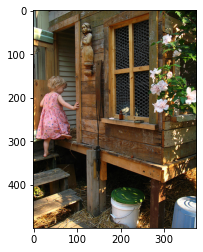

In [12]:
IMG_PATH = ROOT + "Flickr_Data/Flickr_Data/Images/"
img = cv2.imread(IMG_PATH+'1000268201_693b08cb0e.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [13]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence

In [14]:
clean_text("A Cat is sitting at a table # 12")

'cat is sitting at table'

In [15]:
# clean all captions
for key,caption_list in dict.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [16]:
dict['1000268201_693b08cb0e'] #cleaned dict

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [17]:
with open("descriptions_1.txt","w") as f:
    f.write(str(dict))

In [18]:
descriptions = None
with open("descriptions_1.txt","r") as f:
        descriptions = f.read()

In [19]:
descriptions = descriptions.replace("'","\"")

In [20]:
descriptions = json.loads(descriptions)

In [21]:
len(descriptions)

8092

In [22]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
        

In [23]:
len(vocab) # Length of Unique words

8424

In [24]:
# total words in all sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(word) for sentence in descriptions[key] for word in sentence.split() ]

In [25]:
len(total_words)

373837

In [26]:
# total unique words
words_freq = collections.Counter(total_words)
len(words_freq)

8424

In [27]:
# filtering words on some threshold
threshold = 10
sorted_total_words = sorted(words_freq.items(),reverse=True,key=lambda x:x[1])
useful_words = [word for word in sorted_total_words if word[1] > threshold]

In [28]:
len(useful_words)

1845

## Preprocessing the Image Training and Testing data

In [29]:
train_data = readTextFile(ROOT + "Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_data = readTextFile(ROOT + "Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [30]:
train = [data.split('.')[0] for data in train_data.split('\n')]
test = [data.split('.')[0] for data in test_data.split('\n')]

In [31]:
train_descriptions = {}
for img_id in train:
    if img_id.strip() == '':
        continue
    train_descriptions[img_id] = []
    for des in descriptions[img_id]:
        caption = 'startseq ' + des + ' endseq'
        train_descriptions[img_id].append(caption)

In [32]:
type(train_descriptions)

dict

In [33]:
train[0]

'2513260012_03d33305cf'

In [34]:
# Using PreTrained ResNet model

In [35]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3)) 
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [36]:
model_new = Model(model.input,model.layers[-2].output)

In [37]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224)) # image gets loaded as 224,224,3 
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0) # here we reshaped the image from (224,224,3) to (1,224,224,3) 
                                    #as for resnet50 we need it in batch so image batch would be like (batch_size,224,224,3)
    
    #Normalisation according to resnet50
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


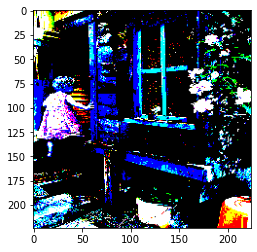

In [38]:
img = preprocess_img(IMG_PATH+'1000268201_693b08cb0e.jpg')
plt.imshow(img[0])

In [81]:
# Encoding all the Images
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
#     print(feature_vector.shape)
    return feature_vector

In [82]:
encode_img(IMG_PATH+'1000268201_693b08cb0e.jpg')

array([0.06535922, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [37]:
# encoding_test_dict = {} # contains all the encoded images

# start_t = time()

# for ix,img_id in enumerate(test):
#     if img_id.strip() != "":
#         encoded_image = encode_img(IMG_PATH + img_id + '.jpg')
#         encoding_test_dict[img_id] = encoded_image

#         if ix%100 == 0:
#             print(f"Encoded image progress : {ix}")

# end_t = time()
# print(f"Total time taken {end_t - start_t}")

In [39]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(useful_words):
    if word[0].strip() != "":
        word_to_idx[word[0]] = i+1 # adding 1 as we have to use 0th 
        idx_to_word[i+1] = word[0]

In [40]:
print(idx_to_word[1])
print(word_to_idx['in'])

in
1


In [40]:
# adding speacial character startseq and endseq in dictionary

In [41]:
last_idx = len(idx_to_word)

idx_to_word[last_idx + 1] = 'startseq'
word_to_idx['startseq'] = last_idx

idx_to_word[last_idx + 2] = 'endseq'
word_to_idx['endseq'] = last_idx + 2

vocab_size = len(idx_to_word) + 1
print(f"Vocab Size {vocab_size}")

Vocab Size 1848


In [42]:
# finding the maximum caption length to make embedding 

In [43]:
max_len = 0
for id in train_descriptions:
    for caption in train_descriptions[id]:
        max_len = max(max_len,len(caption.split()))

print(max_len)

35


In [44]:
encoding_train = {}
with (open(ROOT + "encoded_train_features.pkl", "rb")) as openfile:
    while True:
        try:
            encoding_train = pickle.load(openfile)
        except EOFError:
            break

# Data Load Generator

In [45]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,Y = [],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            photo = encoding_train[key]
            
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    # padding the captions sequence with 0 
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    Y.append(yi)
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(Y)]
                    
                    X1,X2,Y = [],[],[]
                    n = 0
                    
    

# Word Embeddings

In [46]:
f = open(ROOT + "glove.6B.50d.txt",encoding="utf8")

In [47]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embeddings = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embeddings

In [48]:
f.close()

In [49]:
def get_embeddings():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [50]:
embedding_matrix = get_embeddings()

In [51]:
embedding_matrix.shape

(1848, 50)

In [52]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model Architecture

In [53]:
# Image model component
input_feature_img = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_feature_img)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [54]:
# caption model component
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [55]:
# combining the model
decoder1 = Add()([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
output = Dense(vocab_size,activation='softmax')(decoder2)

In [56]:
# combined model
model = Model(inputs=[input_feature_img,input_captions],outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [57]:
# setting the weights for embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [58]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

# Training

In [59]:
epochs = 5
batch_size = 3
steps = len(train_descriptions)//batch_size

In [60]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit(tuple(generator),epochs=1,steps_per_epoch=steps,verbose=1)
        model.save(ROOT + './model_weights/model_'+str(i)+'.h5')

In [61]:
train()

In [62]:
model = load_model('./model_weights/model_9.h5')

In [63]:
def predict_caption(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == 'endseq':
            break
            
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

            

In [64]:
encoding_test = {}
with (open(ROOT + "encoded_test_features.pkl", "rb")) as openfile:
    while True:
        try:
            encoding_test = pickle.load(openfile)
        except EOFError:
            break


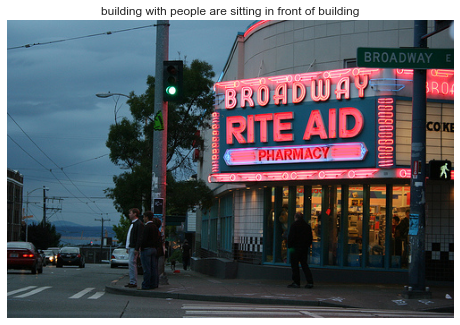

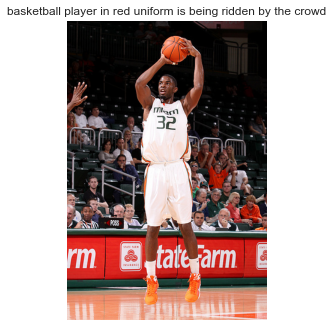

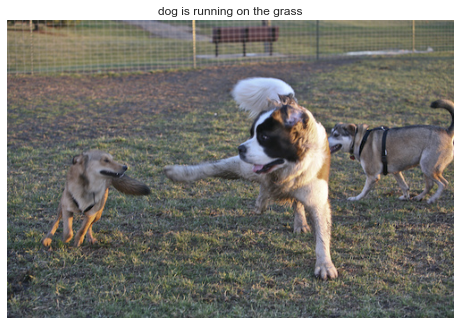

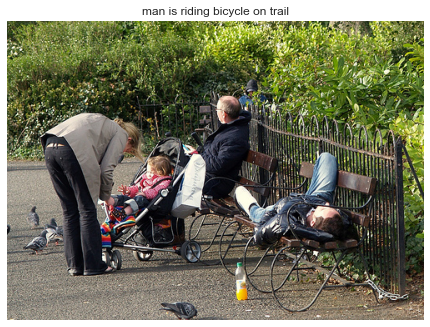

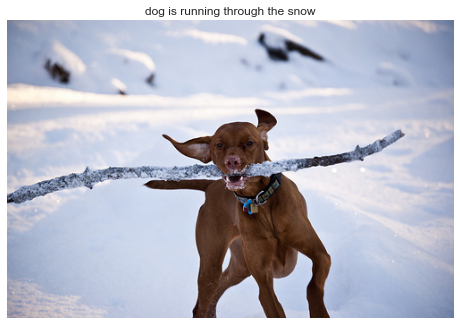

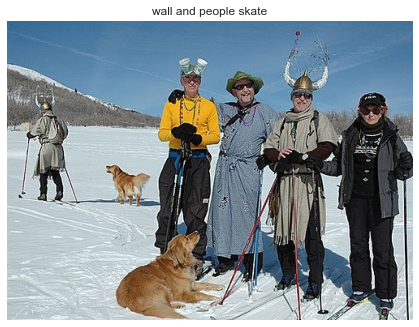

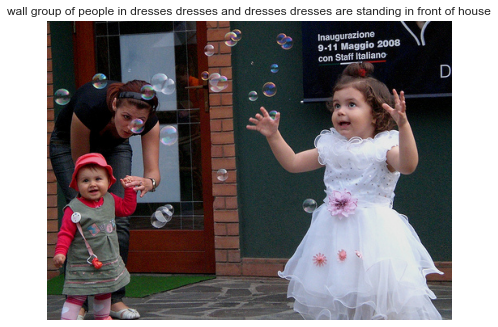

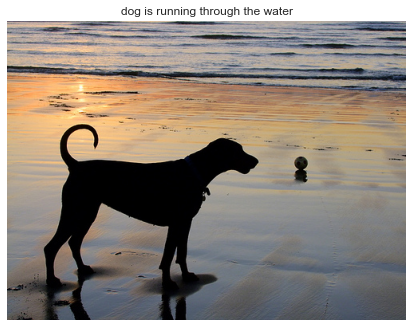

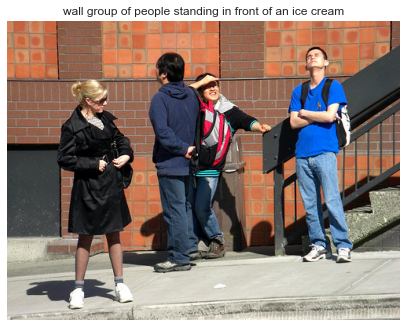

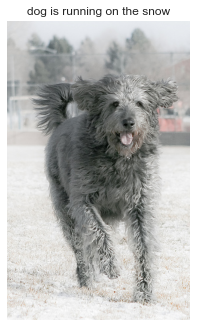

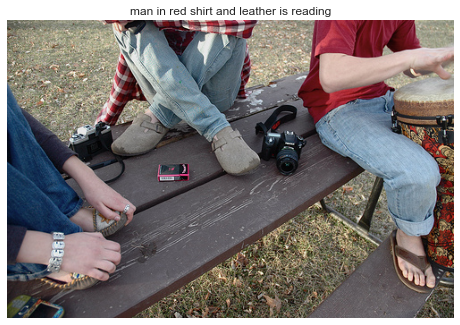

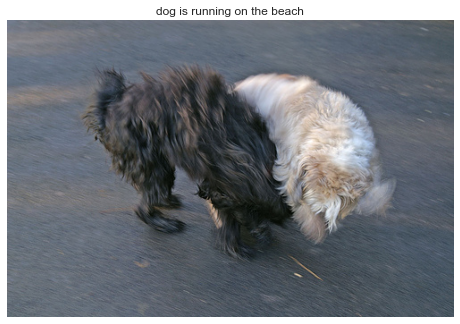

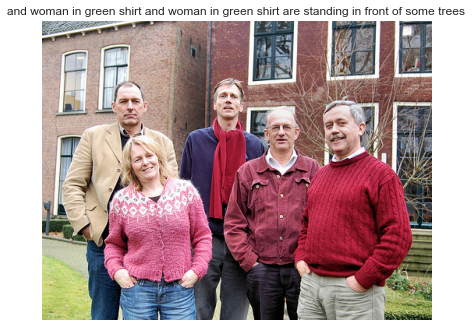

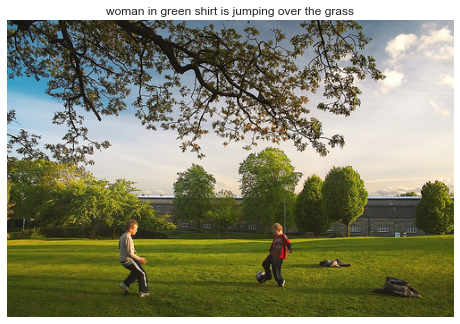

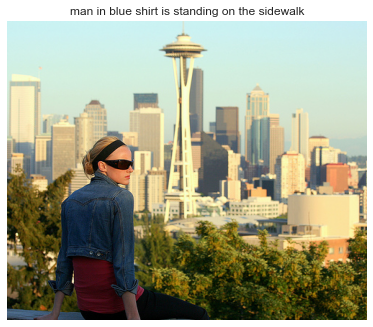

In [68]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(IMG_PATH + img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()